In [1]:
import os
import six.moves.cPickle as pickle
import gzip


def load_data(dataset):
    ''' Loads the dataset

    :type dataset: string
    :param dataset: the path to the dataset (here MNIST)
    '''

    #############
    # LOAD DATA #
    #############

    # Download the MNIST dataset if it is not present
    data_dir, data_file = os.path.split(dataset)
    if data_dir == "" and not os.path.isfile(dataset):
        # Check if dataset is in the data directory.
        new_path = os.path.join(
            os.path.split(__file__)[0],
            #"..",
            #"data",
            dataset
        )
        if os.path.isfile(new_path) or data_file == 'mnist.pkl.gz':
            dataset = new_path

    if (not os.path.isfile(dataset)) and data_file == 'mnist.pkl.gz':
        from six.moves import urllib
        origin = (
            'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
        )
        print('Downloading data from %s' % origin)
        urllib.request.urlretrieve(origin, dataset)

    print('... loading data')

    # Load the dataset
    with gzip.open(dataset, 'rb') as f:
        try:
            train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
        except:
            train_set, valid_set, test_set = pickle.load(f)
    # train_set, valid_set, test_set format: tuple(input, target)
    # input is a numpy.ndarray of 2 dimensions (a matrix)
    # where each row corresponds to an example. target is a
    # numpy.ndarray of 1 dimension (vector) that has the same length as
    # the number of rows in the input. It should give the target
    # to the example with the same index in the input.
    print('dataset is loaded')

In [2]:
import numpy as np
# load the MNIST dataset
dataset = 'mnist.pkl.gz'
number_train_samples = 40000 #Max = 50 000


with gzip.open(dataset, 'rb') as f:
    try:
        train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
    except:
        train_set, valid_set, test_set = pickle.load(f)

train_set_x, train_set_y = train_set
train_set_x, train_set_y = np.array(train_set_x), np.array(train_set_y)
train_set_x = train_set_x[0:number_train_samples,:]
valid_set_x, valid_set_y = valid_set
valid_set_x, valid_set_y  = np.array(valid_set_x), np.array(valid_set_y)
test_set_x, test_set_y = test_set
test_set_x, test_set_y = np.array(test_set_x), np.array(test_set_y)

#train_set_x = (train_set_x-127.5)/127.5
train_set_x.shape = (number_train_samples,28,28,1)
#valid_set_x = (valid_set_x-127.5)/127.5
valid_set_x.shape = (10000,28,28,1)
#test_set_x = (test_set_x-127.5)/127.5
test_set_x.shape = (10000,28,28,1)

In [3]:
###Neural network models
from keras import layers
from keras.layers import Input, Dense, Reshape, Flatten, Embedding, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2DTranspose, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

latent_size = 100

Using TensorFlow backend.


In [4]:
def build_generator(latent_size):
    # we will map z, where z is a latent vector, to image space (..., 28, 28, 1)
    cnn = Sequential()

    cnn.add(Dense(3 * 3 * 100, input_dim=latent_size, activation='relu'))
    cnn.add(Reshape((3, 3, 100)))

    # upsample to (7, 7, ...)
    cnn.add(Conv2DTranspose(16, 5, strides=1, padding='valid',
                            activation='relu',
                            kernel_initializer='glorot_normal'))

    # upsample to (14, 14, ...)
    cnn.add(Conv2DTranspose(8, 5, strides=2, padding='same',
                            activation='relu',
                            kernel_initializer='glorot_normal'))

    # upsample to (28, 28, ...)
    cnn.add(Conv2DTranspose(1, 5, strides=2, padding='same',
                            activation='tanh',
                            kernel_initializer='glorot_normal'))

    # this is the z space commonly referred to in GAN papers
    latent = Input(shape=(latent_size, ))

    # hadamard product between z-space and a class conditional embedding
    fake_image = cnn(latent)

    return Model(latent, fake_image)


gen = build_generator(latent_size)
gen.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         134325    
Total params: 134,325
Trainable params: 134,325
Non-trainable params: 0
_________________________________________________________________


In [5]:
def build_discriminator():
    # build a relatively standard conv net, with LeakyReLUs as suggested in
    # the reference paper
    cnn = Sequential()

    cnn.add(Conv2D(16, 3, padding='same', strides=2,
                   input_shape=(28, 28, 1)))
    cnn.add(LeakyReLU(0.2))
    cnn.add(Dropout(0.3))

    cnn.add(Conv2D(16, 3, padding='same', strides=1))
    cnn.add(LeakyReLU(0.2))
    cnn.add(Dropout(0.3))

    cnn.add(Conv2D(32, 3, padding='same', strides=2))
    cnn.add(LeakyReLU(0.2))
    cnn.add(Dropout(0.3))

    cnn.add(Conv2D(32, 3, padding='same', strides=1))
    cnn.add(LeakyReLU(0.2))
    cnn.add(Dropout(0.3))

    cnn.add(Flatten())

    image = Input(shape=(28, 28, 1))

    features = cnn(image)

    # first output (name=generation) is whether or not the discriminator
    # thinks the image that is being shown is fake, and the second output
    # (name=auxiliary) is the class that the discriminator thinks the image
    # belongs to.
    fake = Dense(1, activation='sigmoid', name='generation')(features)

    return Model(image, fake)

discrim = build_discriminator()
discrim.compile(loss='binary_crossentropy', optimizer=Adam())
discrim.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 1568)              16368     
_________________________________________________________________
generation (Dense)           (None, 1)                 1569      
Total params: 17,937
Trainable params: 17,937
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Combined model

inputGAN = Input(shape=[latent_size])
fake_img = gen(inputGAN)
discrim.trainable = False
res = discrim(fake_img)
GAN = Model(inputGAN,res)
GAN.compile(loss='binary_crossentropy', optimizer=Adam())

In [7]:
from sklearn.utils import shuffle

def discriminator_training(generator, discriminator, batch_size, epochs, latent_size):
    
    for i in range(0, epochs):
        #Generate fake images with generator
        noise_vec = np.random.uniform(-1, 1, (number_train_samples, latent_size))
        fake_images = generator.predict(noise_vec)
        y_fake = np.full((number_train_samples), 0.05)

        #Concatenate fake and real images
        X = np.concatenate([train_set_x,fake_images])
        y_true = np.full((number_train_samples),0.95)
        Y = np.concatenate([y_true,y_fake])
        
        X,Y = shuffle(X,Y)
        discriminator.fit(X,Y, batch_size = batch_size)
        
def generator_training(GAN, generator, discriminator, batch_size, epochs, latent_size):
    
    for i in range(0, epochs):
        noise_vec = np.random.uniform(-1, 1, (2*number_train_samples, latent_size))
        #We want the generated images to be predicted as real images
        label_y = np.full((2*number_train_samples), 0.95)
        GAN.fit(noise_vec,label_y, batch_size = batch_size)  

In [8]:
import matplotlib.pyplot as plt

def grey2rgb(img):
    new_img = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            for k in range(0,3):
                new_img.append(img[i][j])
    new_img = np.array(new_img, dtype=float).reshape(img.shape[0], img.shape[1], 3)
    return new_img

def plot_img(img):
    print(img.shape)
    print("Image with confidence accorded by discriminator : ")
    print(discrim.predict(img))
    img = img*255
    img = np.array(img, dtype=int)
    img.shape = (28,28)
    img = grey2rgb(img)
    plt.imshow(img)
    plt.show()
    
def plot_generated_real_img():
    noise_vec = np.random.uniform(-1, 1, (1, latent_size))
    img = gen.predict(noise_vec)
    plot_img(img)

    img = train_set_x[15]
    img.shape = (1,28,28,1)
    plot_img(img)

Epoch 1/1
80000/80000 [==============================] - 54s - loss: 0.2089    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.04352881]]


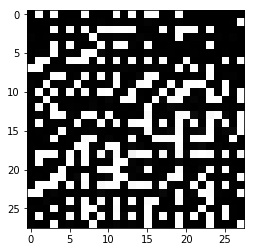

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.91164023]]


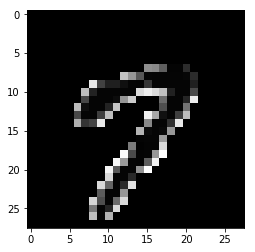

Epoch 1/1
80000/80000 [==============================] - 66s - loss: 0.2061    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94313979]]


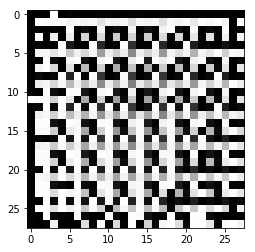

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.91164023]]


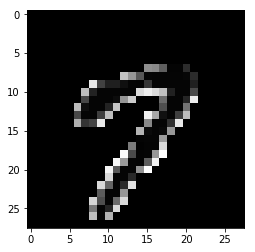

Epoch 1/1
80000/80000 [==============================] - 53s - loss: 0.2028    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.04331299]]


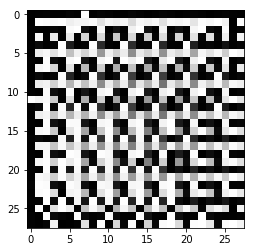

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94087648]]


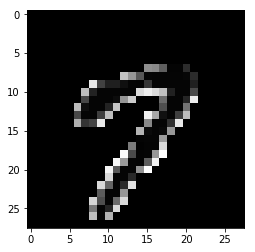

Epoch 1/1
80000/80000 [==============================] - 62s - loss: 0.2042    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95254201]]


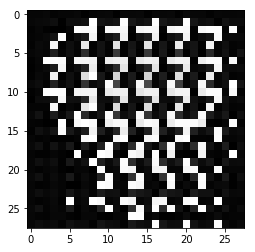

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94087648]]


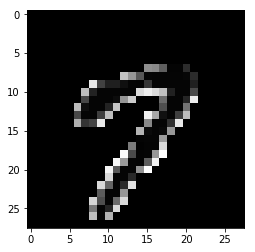

Epoch 1/1
80000/80000 [==============================] - 52s - loss: 0.2030    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.0448381]]


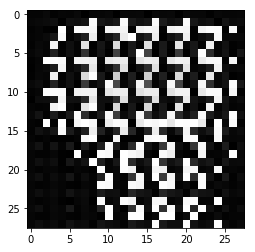

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94438463]]


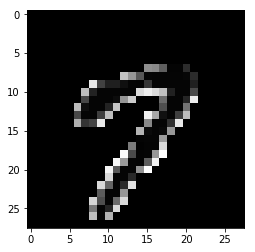

Epoch 1/1
80000/80000 [==============================] - 60s - loss: 0.2175    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94954842]]


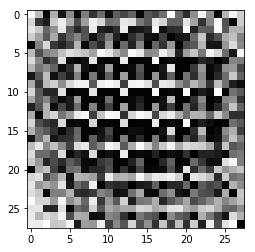

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94438463]]


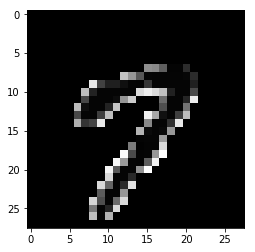

Epoch 1/1
80000/80000 [==============================] - 51s - loss: 0.2035    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.03684687]]


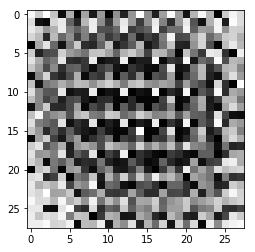

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94165486]]


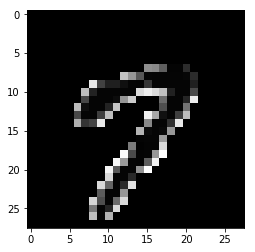

Epoch 1/1
80000/80000 [==============================] - 59s - loss: 0.2073    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.93956888]]


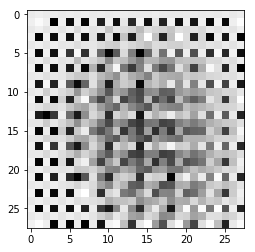

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94165486]]


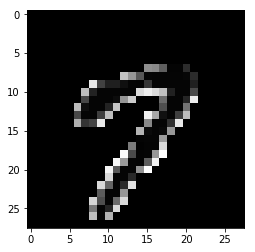

Epoch 1/1
80000/80000 [==============================] - 55s - loss: 0.2037    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.04074763]]


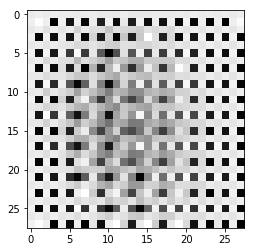

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94281203]]


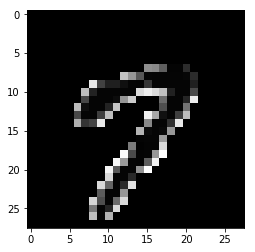

Epoch 1/1
80000/80000 [==============================] - 61s - loss: 0.2132    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94465488]]


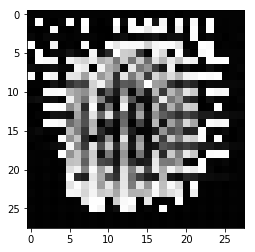

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94281203]]


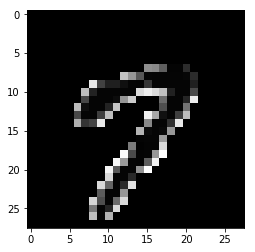

Epoch 1/1
80000/80000 [==============================] - 52s - loss: 0.2051    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.04121704]]


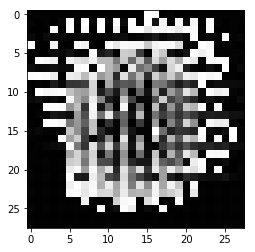

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94363147]]


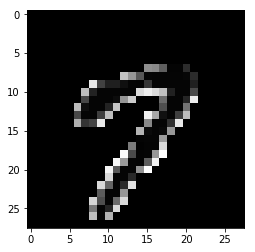

Epoch 1/1
80000/80000 [==============================] - 59s - loss: 0.2099    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94223118]]


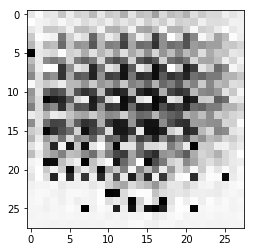

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94363147]]


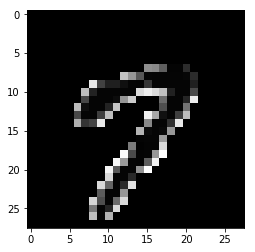

Epoch 1/1
80000/80000 [==============================] - 52s - loss: 0.2053    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.03854456]]


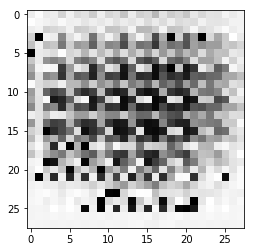

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94998586]]


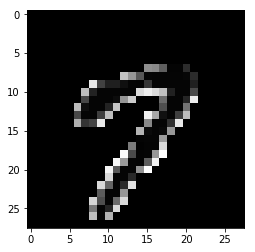

Epoch 1/1
80000/80000 [==============================] - 59s - loss: 0.2079    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95112395]]


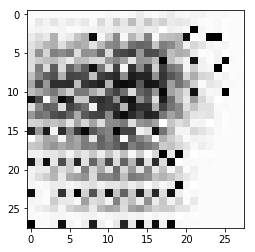

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94998586]]


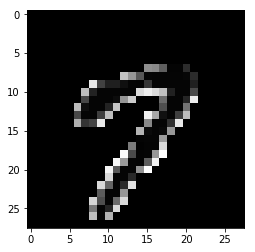

Epoch 1/1
80000/80000 [==============================] - 52s - loss: 0.2055    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.03758007]]


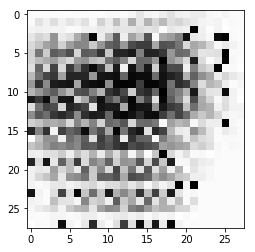

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.93835223]]


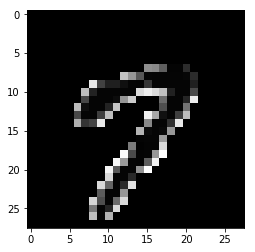

Epoch 1/1
80000/80000 [==============================] - 58s - loss: 0.2088    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94068456]]


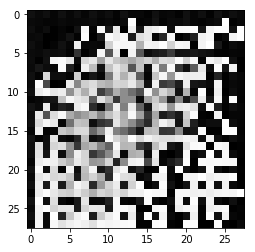

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.93835223]]


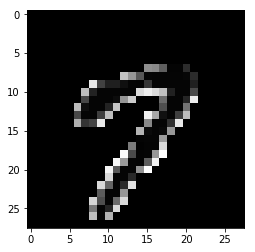

Epoch 1/1
80000/80000 [==============================] - 52s - loss: 0.2042    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.04662977]]


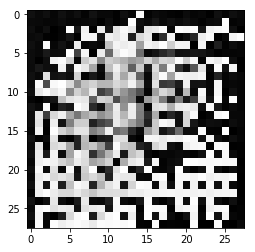

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.9468987]]


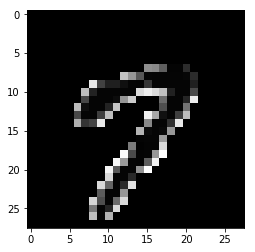

Epoch 1/1
80000/80000 [==============================] - 58s - loss: 0.2069    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94571316]]


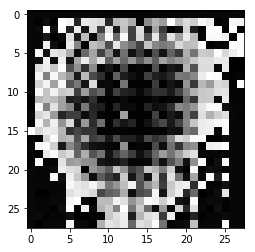

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.9468987]]


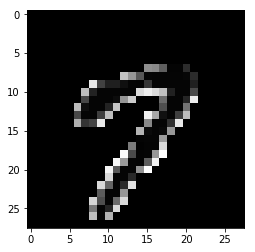

Epoch 1/1
80000/80000 [==============================] - 49s - loss: 0.2052    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.04537608]]


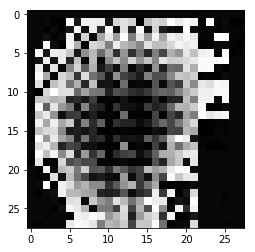

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94313365]]


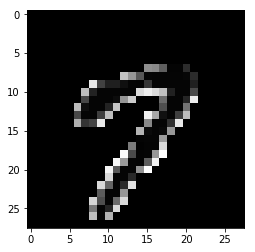

Epoch 1/1
80000/80000 [==============================] - 58s - loss: 0.2097    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.93910575]]


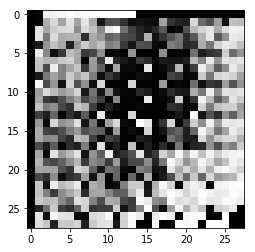

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94313365]]


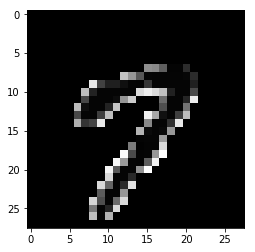

In [9]:
#Pre-training of the discriminator
#discriminator_training(gen,discrim,batch_size=64,epochs=1,latent_size=latent_size)

#Alternative training of the GAN
epochs = 20
k = 1   #discriminator trained k times, then generator trained once

for i in range(0,epochs):
    discriminator_training(gen,discrim,batch_size=64,epochs=k,latent_size=latent_size)
    plot_generated_real_img()
    
    generator_training(GAN,gen,discrim,batch_size=64,epochs=1,latent_size=latent_size)
    plot_generated_real_img()


Epoch 1/1
80000/80000 [==============================] - 51s - loss: 0.2036    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.04249086]]


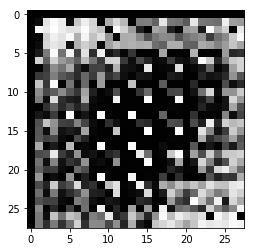

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94543964]]


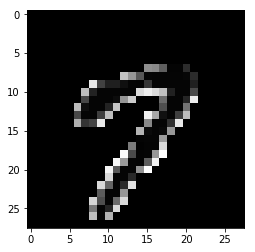

Epoch 1/1
80000/80000 [==============================] - 59s - loss: 0.2105    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.93434364]]


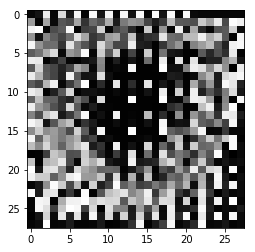

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94543964]]


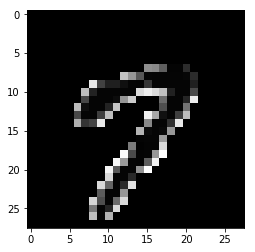

Epoch 1/1
80000/80000 [==============================] - 51s - loss: 0.2029    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.04543006]]


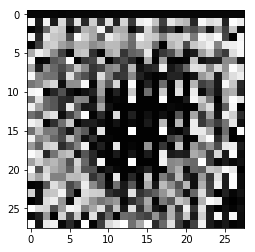

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94737816]]


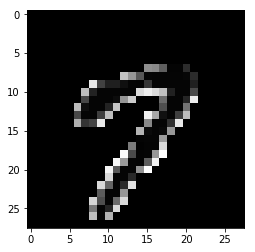

Epoch 1/1
80000/80000 [==============================] - 60s - loss: 0.2111    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94039726]]


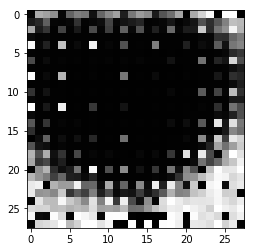

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94737816]]


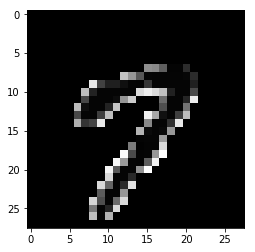

Epoch 1/1
80000/80000 [==============================] - 52s - loss: 0.2023    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.04862632]]


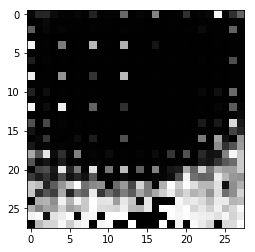

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94366974]]


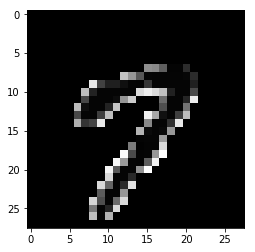

Epoch 1/1
80000/80000 [==============================] - 57s - loss: 0.2277    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.92986143]]


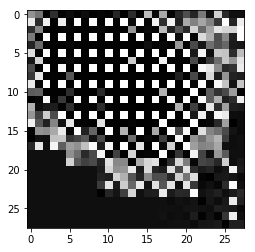

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94366974]]


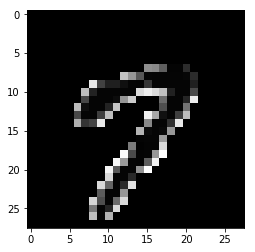

Epoch 1/1
80000/80000 [==============================] - 51s - loss: 0.2026    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.05767696]]


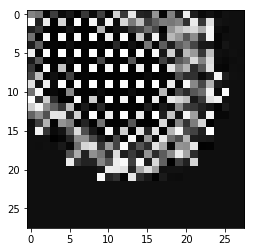

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95381171]]


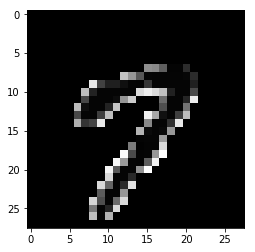

Epoch 1/1
80000/80000 [==============================] - 61s - loss: 0.2164    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95182663]]


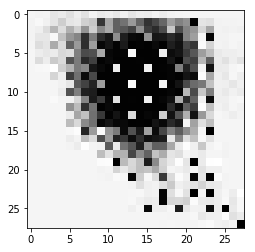

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95381171]]


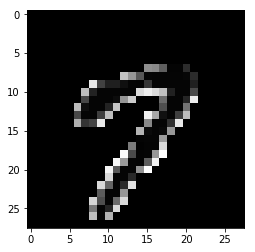

Epoch 1/1
80000/80000 [==============================] - 52s - loss: 0.2049    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.04102262]]


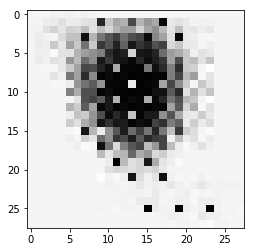

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.93982875]]


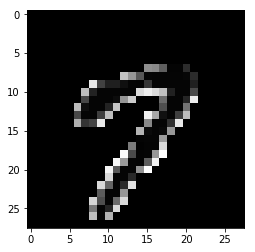

Epoch 1/1
80000/80000 [==============================] - 60s - loss: 0.2149    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.93403757]]


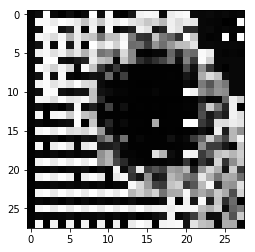

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.93982875]]


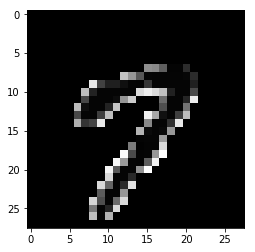

Epoch 1/1
80000/80000 [==============================] - 51s - loss: 0.2065    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.04549483]]


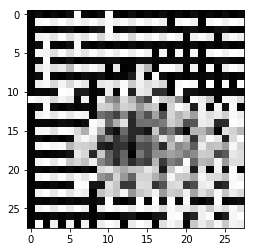

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.93781608]]


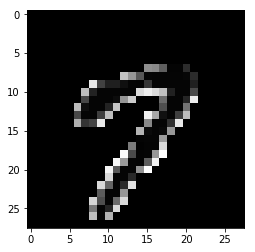

Epoch 1/1
80000/80000 [==============================] - 58s - loss: 0.2080    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95106423]]


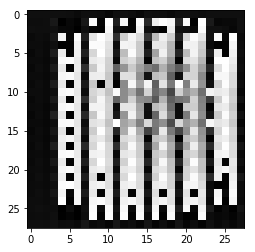

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.93781608]]


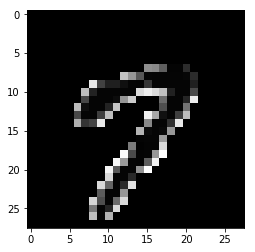

Epoch 1/1
80000/80000 [==============================] - 53s - loss: 0.2042    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.05297871]]


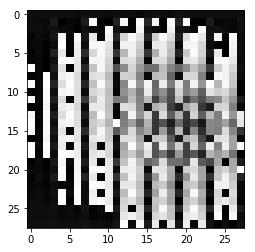

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95023328]]


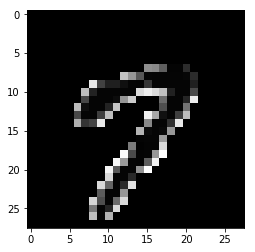

Epoch 1/1
80000/80000 [==============================] - 57s - loss: 0.2119    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94458425]]


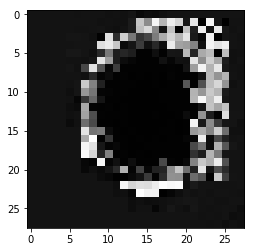

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95023328]]


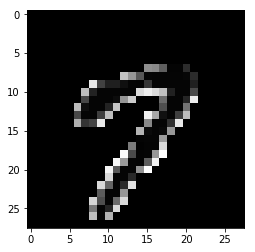

Epoch 1/1
80000/80000 [==============================] - 50s - loss: 0.2041    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.05902044]]


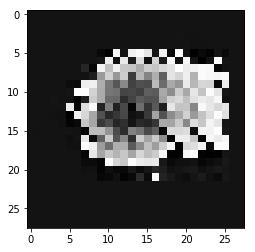

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.9570505]]


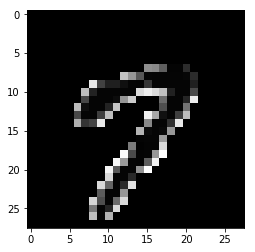

Epoch 1/1
80000/80000 [==============================] - 62s - loss: 0.2122    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94910502]]


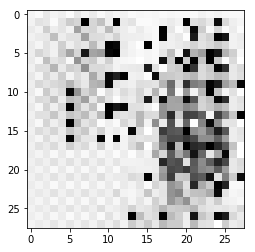

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.9570505]]


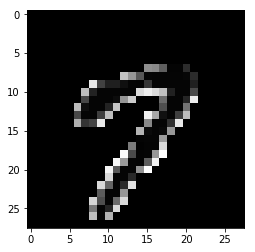

Epoch 1/1
80000/80000 [==============================] - 48s - loss: 0.2049    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.04721765]]


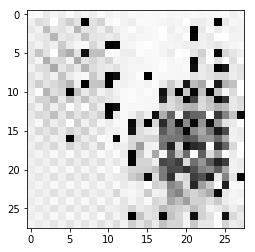

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94402605]]


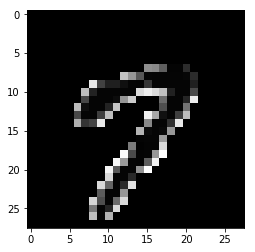

Epoch 1/1
80000/80000 [==============================] - 58s - loss: 0.2152    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.9397198]]


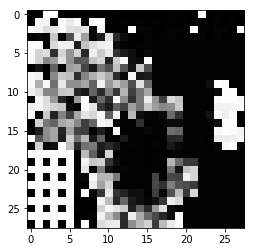

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94402605]]


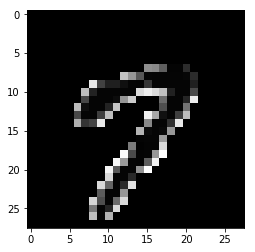

Epoch 1/1
80000/80000 [==============================] - 49s - loss: 0.2087    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.04355839]]


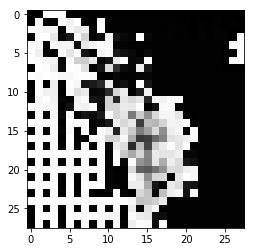

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.9475072]]


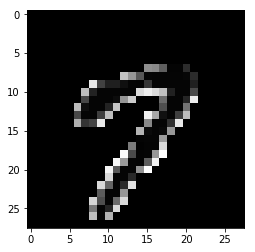

Epoch 1/1
80000/80000 [==============================] - 54s - loss: 0.2136    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.93882519]]


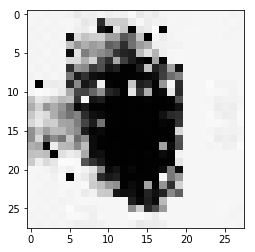

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.9475072]]


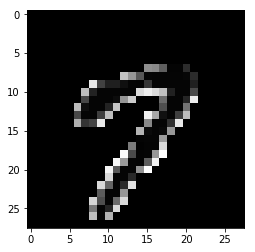

Epoch 1/1
80000/80000 [==============================] - 48s - loss: 0.2032    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.04589287]]


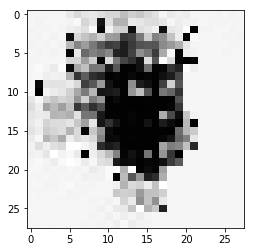

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.9475686]]


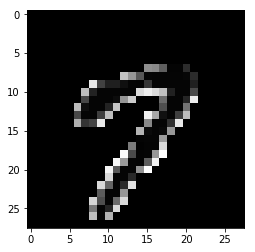

Epoch 1/1
80000/80000 [==============================] - 60s - loss: 0.2137    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.93973863]]


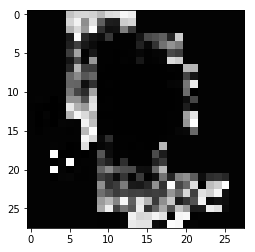

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.9475686]]


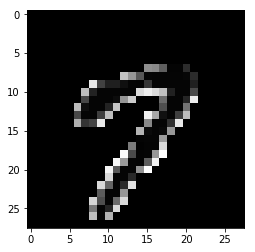

Epoch 1/1
80000/80000 [==============================] - 51s - loss: 0.2067    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.03466792]]


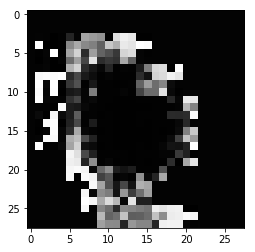

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.9493553]]


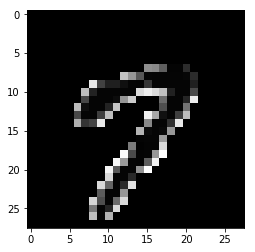

Epoch 1/1
80000/80000 [==============================] - 61s - loss: 0.2153    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95402628]]


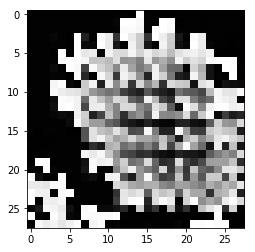

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.9493553]]


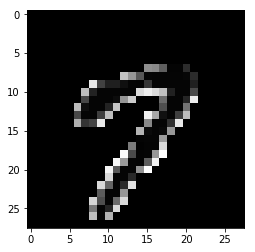

Epoch 1/1
80000/80000 [==============================] - 49s - loss: 0.2059    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.04340926]]


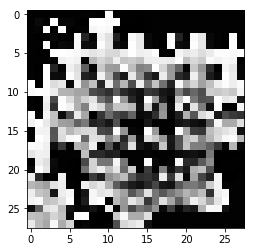

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95477581]]


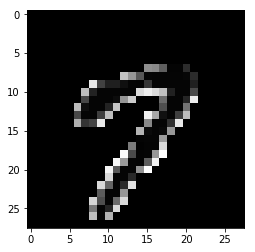

Epoch 1/1
80000/80000 [==============================] - 56s - loss: 0.2159    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.9457621]]


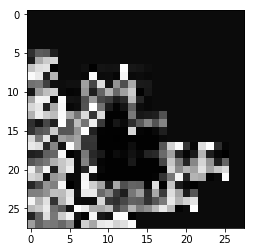

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95477581]]


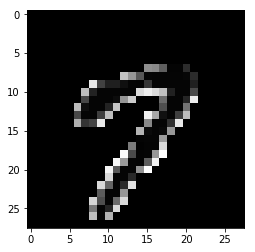

Epoch 1/1
80000/80000 [==============================] - 49s - loss: 0.2061    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.04607749]]


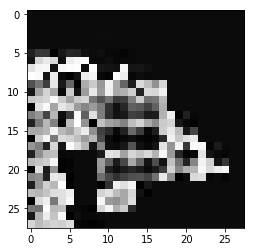

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95646954]]


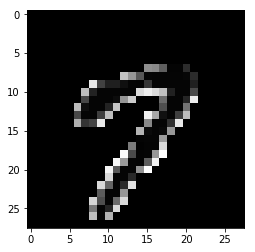

Epoch 1/1
80000/80000 [==============================] - 55s - loss: 0.2093    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95320529]]


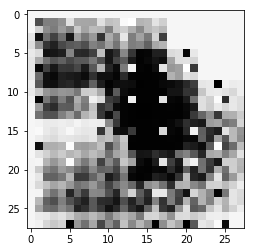

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95646954]]


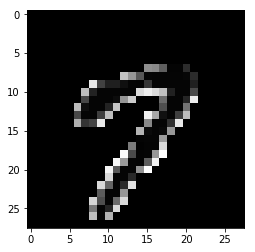

Epoch 1/1
80000/80000 [==============================] - 49s - loss: 0.2049    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.03869975]]


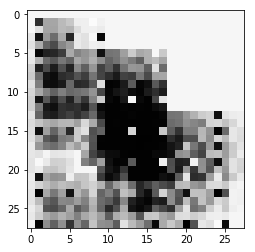

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94707876]]


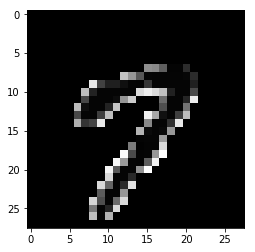

Epoch 1/1
80000/80000 [==============================] - 59s - loss: 0.2199    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95419157]]


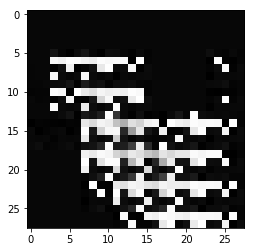

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94707876]]


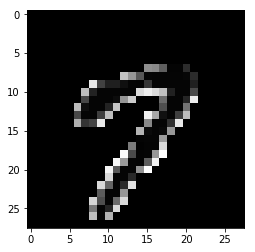

Epoch 1/1
80000/80000 [==============================] - 49s - loss: 0.2084    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.03936421]]


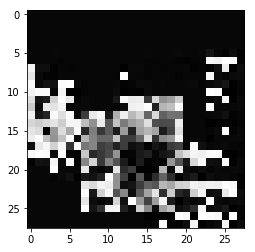

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95768148]]


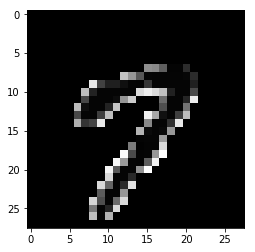

Epoch 1/1
80000/80000 [==============================] - 56s - loss: 0.2080    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94542933]]


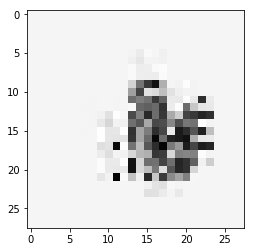

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95768148]]


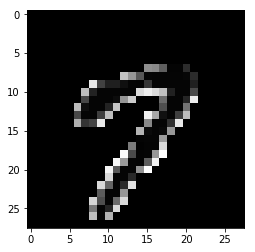

Epoch 1/1
80000/80000 [==============================] - 50s - loss: 0.2059    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.04066959]]


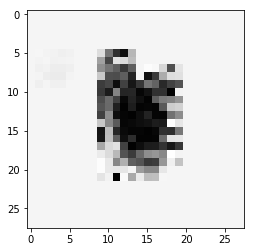

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94235337]]


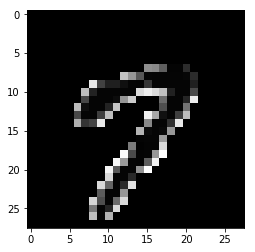

Epoch 1/1
80000/80000 [==============================] - 57s - loss: 0.2167    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94621783]]


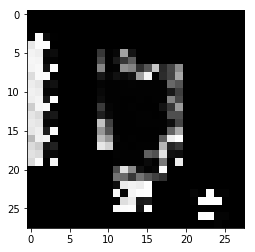

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94235337]]


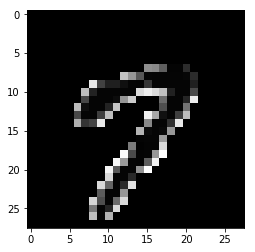

Epoch 1/1
80000/80000 [==============================] - 52s - loss: 0.2123    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.02897881]]


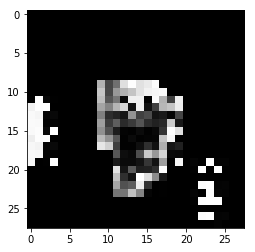

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.93772811]]


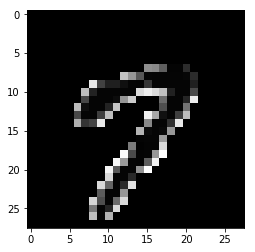

Epoch 1/1
80000/80000 [==============================] - 58s - loss: 0.2180    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.92748201]]


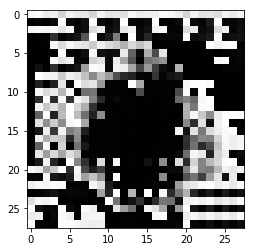

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.93772811]]


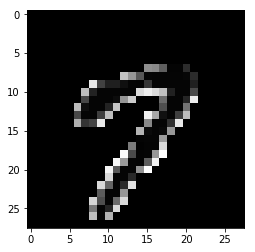

Epoch 1/1
80000/80000 [==============================] - 49s - loss: 0.2050    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.04649695]]


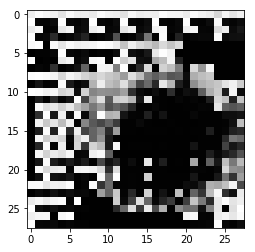

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95624363]]


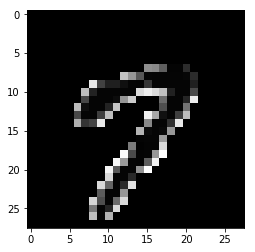

Epoch 1/1
80000/80000 [==============================] - 57s - loss: 0.2115    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95270658]]


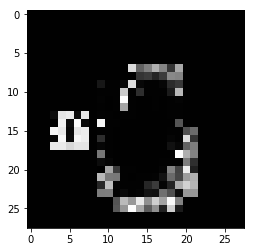

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95624363]]


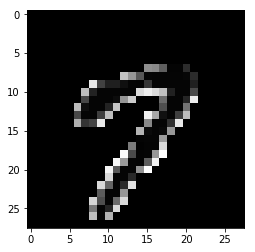

Epoch 1/1
80000/80000 [==============================] - 49s - loss: 0.2067    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.03825646]]


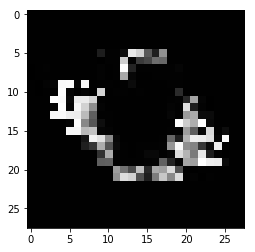

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95133495]]


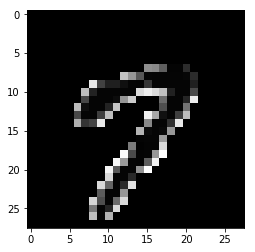

Epoch 1/1
80000/80000 [==============================] - 54s - loss: 0.2175    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94984907]]


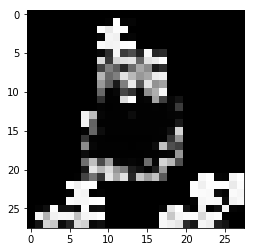

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95133495]]


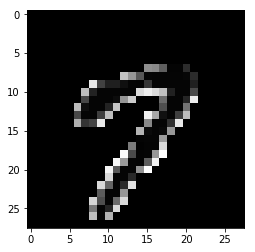

In [10]:
epochs = 20
k = 1   #discriminator trained k times, then generator trained once

for i in range(0,epochs):
    discriminator_training(gen,discrim,batch_size=64,epochs=k,latent_size=latent_size)
    plot_generated_real_img()
    
    generator_training(GAN,gen,discrim,batch_size=64,epochs=1,latent_size=latent_size)
    plot_generated_real_img()

Epoch 1/1
80000/80000 [==============================] - 50s - loss: 0.2075    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.03337599]]


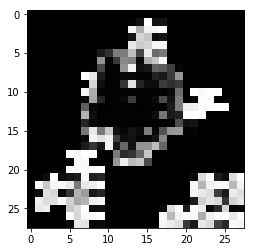

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95757961]]


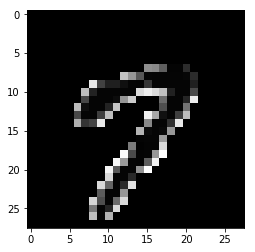

Epoch 1/1
80000/80000 [==============================] - 57s - loss: 0.2177    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.93199497]]


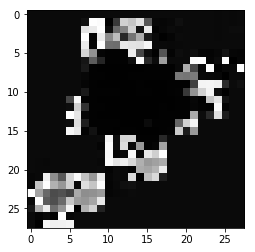

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95757961]]


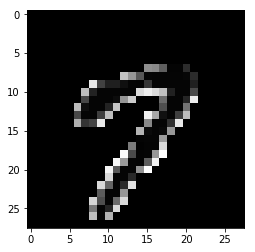

Epoch 1/1
80000/80000 [==============================] - 51s - loss: 0.2044    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.05453803]]


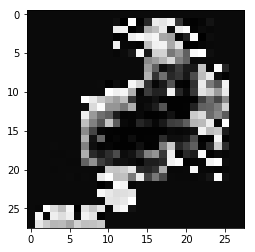

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95514375]]


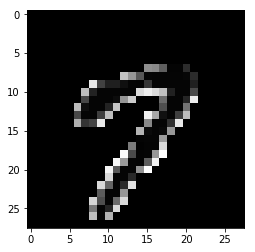

Epoch 1/1
80000/80000 [==============================] - 58s - loss: 0.2086    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95281845]]


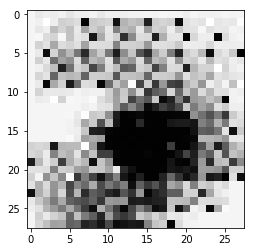

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95514375]]


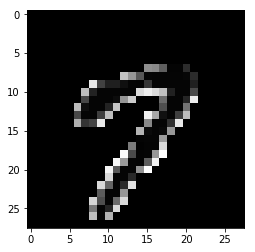

Epoch 1/1
80000/80000 [==============================] - 48s - loss: 0.2060    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.03935792]]


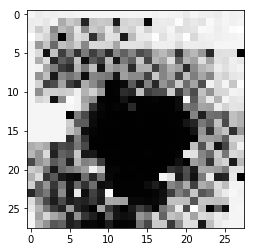

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94832081]]


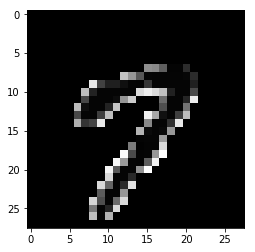

Epoch 1/1
80000/80000 [==============================] - 57s - loss: 0.2169    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.9452824]]


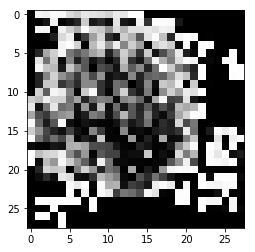

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94832081]]


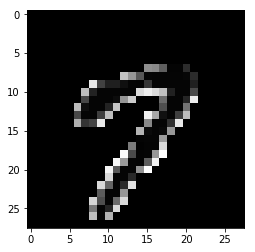

Epoch 1/1
80000/80000 [==============================] - 51s - loss: 0.2058    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.06378859]]


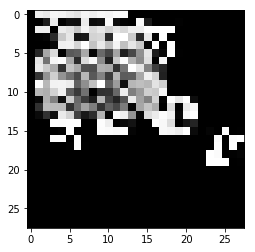

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.9463349]]


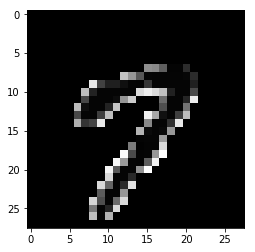

Epoch 1/1
80000/80000 [==============================] - 58s - loss: 0.2148    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.93810636]]


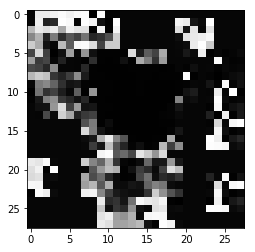

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.9463349]]


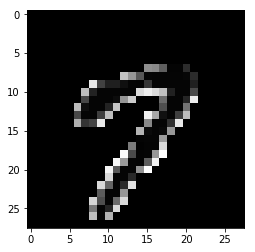

Epoch 1/1
80000/80000 [==============================] - 52s - loss: 0.2058    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.0553903]]


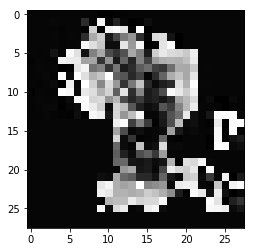

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95848894]]


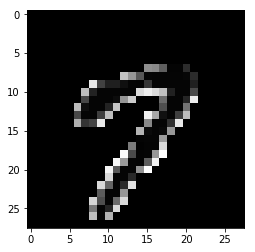

Epoch 1/1
80000/80000 [==============================] - 56s - loss: 0.2080    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95171195]]


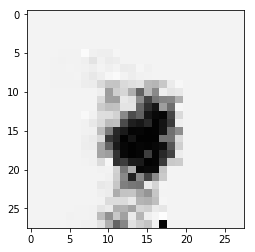

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95848894]]


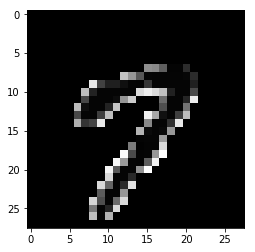

Epoch 1/1
80000/80000 [==============================] - 52s - loss: 0.2057    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.04092098]]


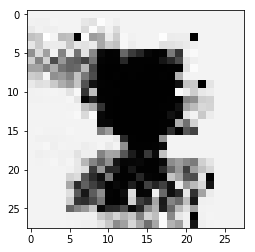

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95211399]]


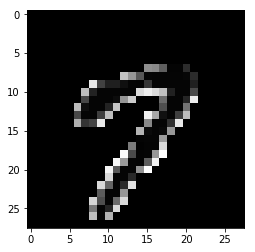

Epoch 1/1
80000/80000 [==============================] - 57s - loss: 0.2196    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94323003]]


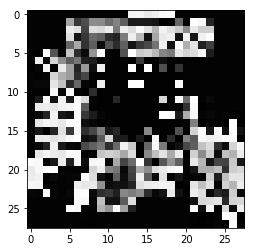

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95211399]]


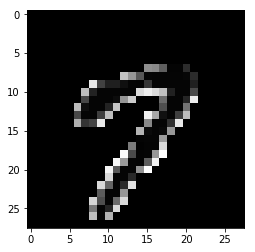

Epoch 1/1
80000/80000 [==============================] - 51s - loss: 0.2072    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.04388367]]


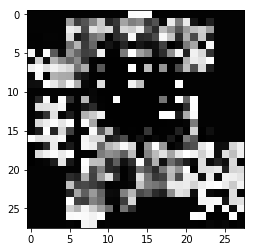

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95931256]]


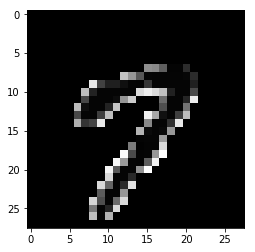

Epoch 1/1
80000/80000 [==============================] - 55s - loss: 0.2122    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94628048]]


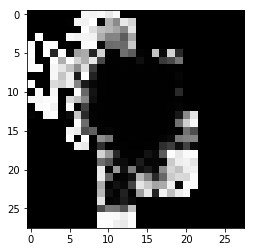

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95931256]]


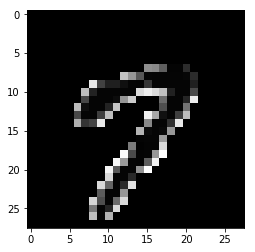

Epoch 1/1
80000/80000 [==============================] - 51s - loss: 0.2089    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.03269354]]


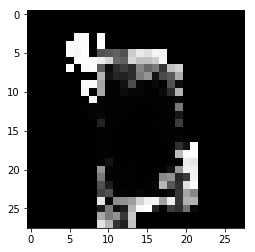

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95460409]]


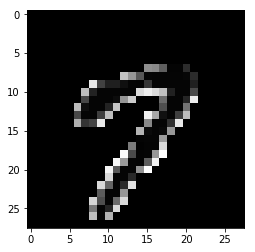

Epoch 1/1
80000/80000 [==============================] - 58s - loss: 0.2169    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95473522]]


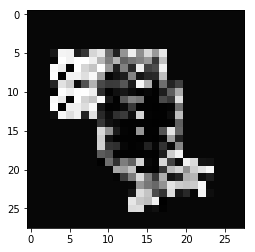

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95460409]]


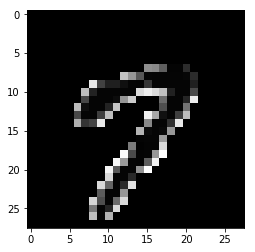

Epoch 1/1
80000/80000 [==============================] - 49s - loss: 0.2055    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.04819656]]


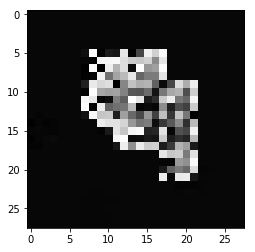

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95647424]]


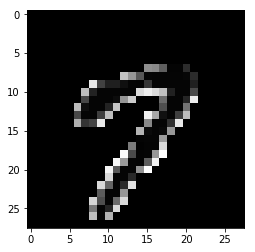

Epoch 1/1
80000/80000 [==============================] - 57s - loss: 0.2086    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95218283]]


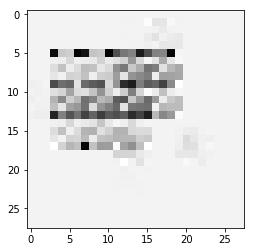

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95647424]]


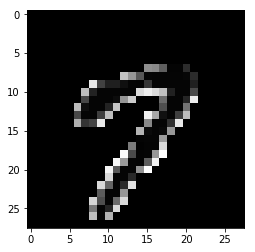

Epoch 1/1
80000/80000 [==============================] - 51s - loss: 0.2065    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.04559426]]


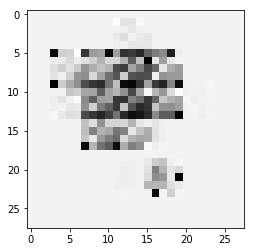

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.93884349]]


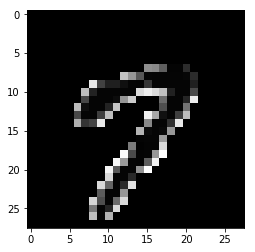

Epoch 1/1
80000/80000 [==============================] - 56s - loss: 0.2184    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94353294]]


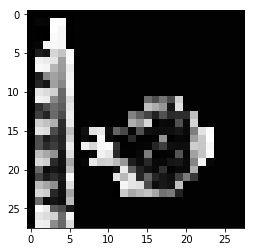

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.93884349]]


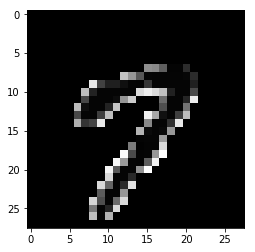

Epoch 1/1
80000/80000 [==============================] - 48s - loss: 0.2093    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.08205265]]


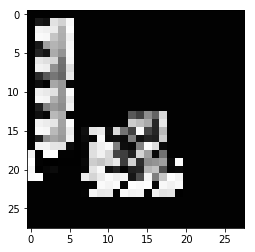

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95375228]]


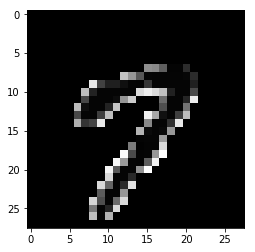

Epoch 1/1
80000/80000 [==============================] - 57s - loss: 0.2147    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94237852]]


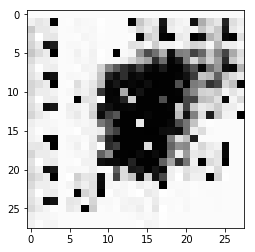

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95375228]]


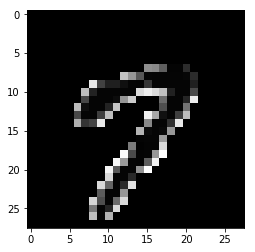

Epoch 1/1
80000/80000 [==============================] - 50s - loss: 0.2054    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.05257444]]


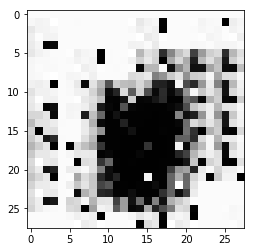

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94844961]]


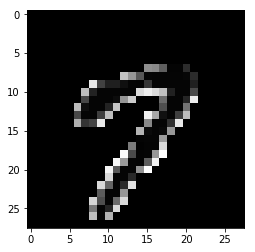

Epoch 1/1
80000/80000 [==============================] - 55s - loss: 0.2141    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94731736]]


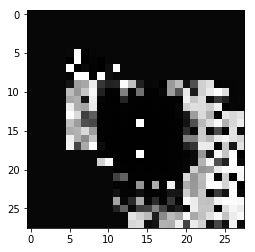

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94844961]]


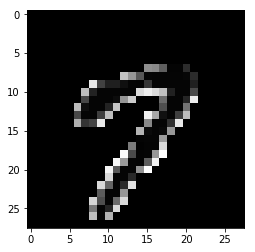

Epoch 1/1
80000/80000 [==============================] - 50s - loss: 0.2058    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.04532126]]


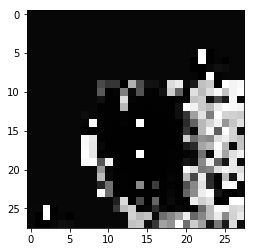

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.96224737]]


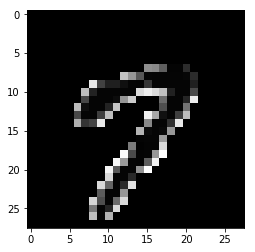

Epoch 1/1
80000/80000 [==============================] - 58s - loss: 0.2083    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95384806]]


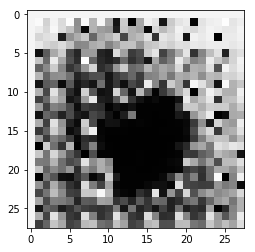

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.96224737]]


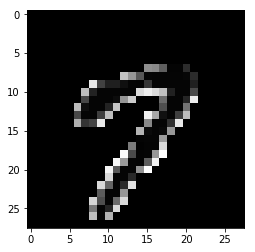

Epoch 1/1
80000/80000 [==============================] - 49s - loss: 0.2043    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.06138726]]


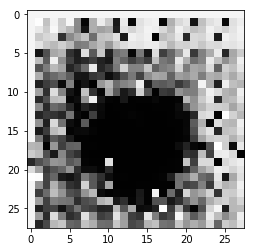

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95754451]]


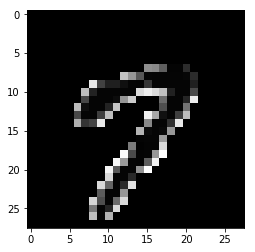

Epoch 1/1
80000/80000 [==============================] - 57s - loss: 0.2132    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95296115]]


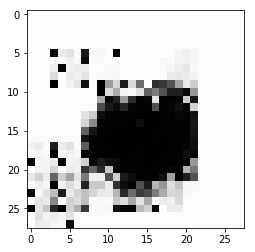

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95754451]]


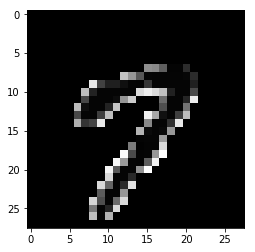

Epoch 1/1
80000/80000 [==============================] - 49s - loss: 0.2072    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.04161375]]


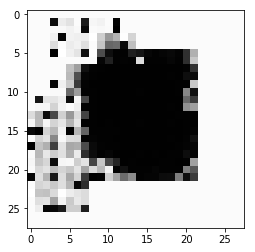

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.93736494]]


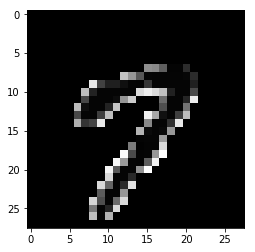

Epoch 1/1
80000/80000 [==============================] - 58s - loss: 0.2154    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.9314869]]


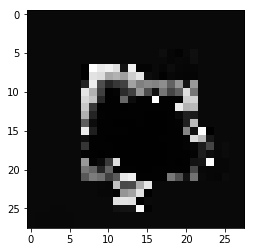

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.93736494]]


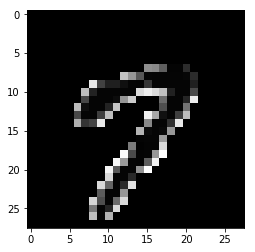

Epoch 1/1
80000/80000 [==============================] - 49s - loss: 0.2069    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.04108122]]


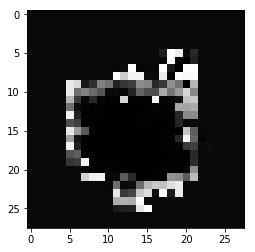

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.96189344]]


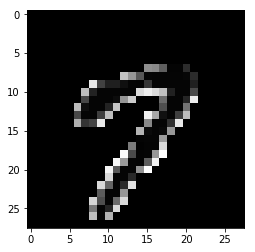

Epoch 1/1
80000/80000 [==============================] - 56s - loss: 0.2204    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95377821]]


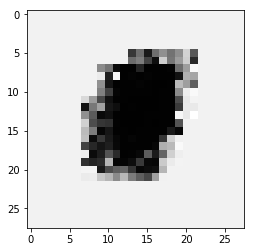

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.96189344]]


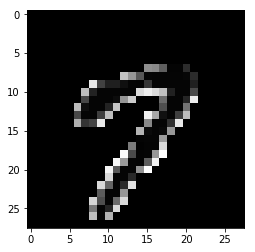

Epoch 1/1
80000/80000 [==============================] - 49s - loss: 0.2078    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.03965019]]


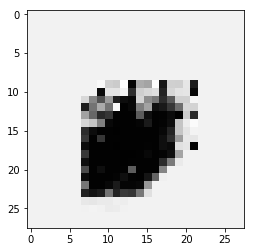

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94915336]]


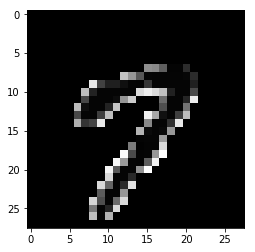

Epoch 1/1
80000/80000 [==============================] - 58s - loss: 0.2173    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94134986]]


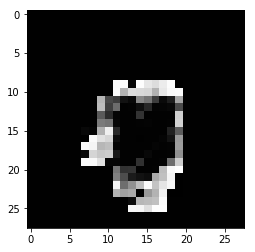

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94915336]]


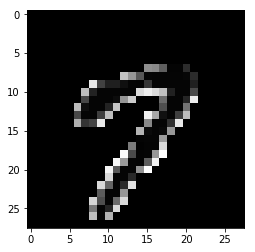

Epoch 1/1
80000/80000 [==============================] - 49s - loss: 0.2112    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.0435245]]


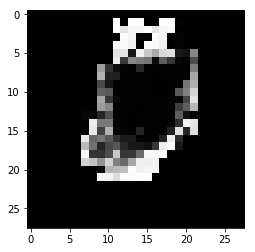

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.9465332]]


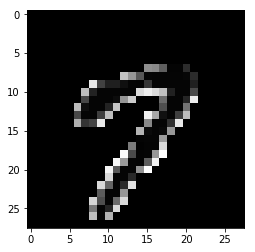

Epoch 1/1
80000/80000 [==============================] - 57s - loss: 0.2232    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.94918847]]


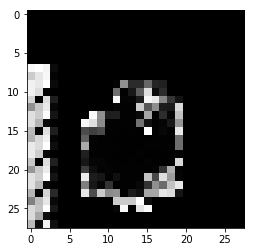

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.9465332]]


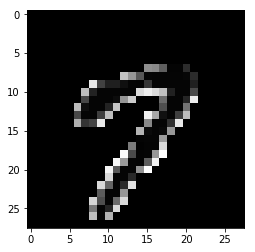

Epoch 1/1
80000/80000 [==============================] - 49s - loss: 0.2056    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.04590862]]


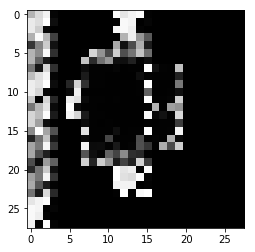

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.96064854]]


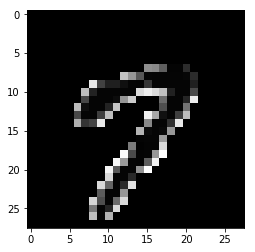

Epoch 1/1
80000/80000 [==============================] - 57s - loss: 0.2202    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95212078]]


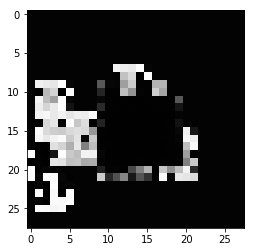

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.96064854]]


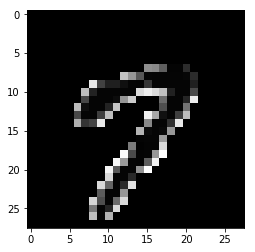

Epoch 1/1
80000/80000 [==============================] - 53s - loss: 0.2076    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.04696031]]


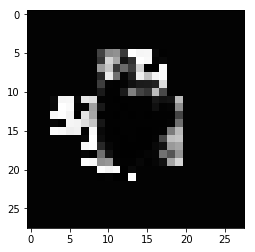

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.96285826]]


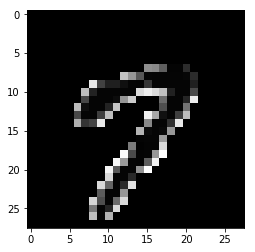

Epoch 1/1
80000/80000 [==============================] - 57s - loss: 0.2055    
(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.95130831]]


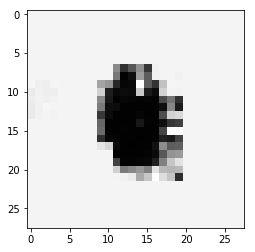

(1, 28, 28, 1)
Image with confidence accorded by discriminator : 
[[ 0.96285826]]


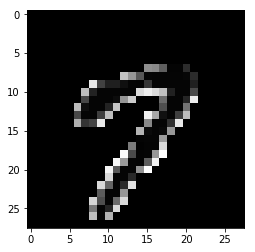

In [11]:
epochs = 20
k = 1   #discriminator trained k times, then generator trained once

for i in range(0,epochs):
    discriminator_training(gen,discrim,batch_size=64,epochs=k,latent_size=latent_size)
    plot_generated_real_img()
    
    generator_training(GAN,gen,discrim,batch_size=64,epochs=1,latent_size=latent_size)
    plot_generated_real_img()